In [1]:
import CHONK_cpp as ch
import numpy as np
import fastscapelib_fortran as fs
import lsdtopytools as lsd
import numba as nb
from matplotlib import pyplot as plt
%matplotlib inline
   
model = ch.ModelRunner( 100, 0, ["drainage_area","move","basic_SPIL"], "D8")
# model.update_int_param("n_rows", 5)


In [2]:

@nb.njit()
def check_stack(stack):
    checker = np.zeros(stack.shape, dtype = np.int32)
    incr = 0
    for i in stack:
        checker[i] = incr
        incr +=1
    return checker

@nb.njit()
def check_rec(stack,rec):
    checker = np.zeros(stack.shape, dtype = np.int32)

    for i in stack[::-1]:
        trec = rec[i]
        checker[trec] += checker[i] + 1
        
    return checker

@nb.njit()
def baselevel(stack,rec,mrec):
    checker = np.zeros(stack.shape, dtype = np.int32)

    for i in stack[::-1]:
        if i == rec[i]:
            checker[i] = 1
            checker[mrec[i,0]] = 2
            print(mrec[i])
        
    return checker
@nb.njit()
def baselevel_2(stack,rec,postsrec,Z):
    checker = np.zeros(stack.shape, dtype = np.int32)

    for i in stack[::-1]:
        if i == rec[i]:
            if rec[i] != postsrec[i]:
                print("node:",Z[i],"rec:",Z[postsrec[i]])
            else:
                print("flub")
                
            checker[i] = 1
            checker[postsrec[i]] = 2
        
    return checker

@nb.njit()
def try_identify_pits(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True or receivers[i,j] == i):
                continue
                
            if(elev[i]<elev[receivers[i,j] ]):
                pits.append(i)
                recapit.append(receivers[i,j])
                ispit = True
                
    return np.array(pits),np.array(recapit)

@nb.njit()
def try_identify_pits_single(receivers, elev, stack):
    pits = []
    recapit = []
    for i in range(receivers.shape[0]):

        if(receivers[i] == -1 or receivers[i] == i):
            continue

        if(elev[i]<elev[receivers[i]]):
            pits.append(i)
            recapit.append(receivers[i])


    return np.array(pits),np.array(recapit)
            
@nb.njit()
def get_delta_elev(receivers, elev, stack):
    pits = []
    for i in range(receivers.shape[0]):
        ispit = False
        for j in range(receivers.shape[1]):
            if(receivers[i,j] == -1 or ispit == True):
                continue
                
            if(elev[i]<elev[receivers[i,j]]):
                pits.append(i)
                ispit = True
                
    return np.array(pits)
            

In [4]:
raster = lsd.raster_loader.load_raster("putna_50_NDF.tif")
Z = np.copy(raster["array"].astype(np.float64).ravel())

fs.fastscape_init()
fs.fastscape_set_nx_ny(raster["ncols"],raster["nrows"])
fs.fastscape_setup()
fs.fastscape_set_xl_yl(raster["x_max"] - raster["x_min"],raster["y_max"] - raster["y_min"] )
fstctx = fs.fastscapecontext
fstctx.p = 3
fstctx.h = raster["array"].astype(np.float64).ravel()
# fs.fastscape_init_h(raster["array"].astype(np.float64).ravel())

fstctx.kf = np.ones_like(fstctx.h) * 1e-3
fstctx.kfsed = 1e-3
fstctx.m = 0.45
fstctx.n = 1.
fstctx.kd = np.ones_like(fstctx.h) * 1e-3
fstctx.kdsed = 1e-3
fstctx.g1 = 1.0
fstctx.g2 = 1.0
fstctx.ibc = 1111
fs.fastscape_set_dt(1000)
fs.flowrouting_first_stack ()
prestack = np.copy(fstctx.stack.astype('int') - 1)
prerec = np.copy(fstctx.rec.astype('int') - 1)
fs.flowRouting_reroute_local_minima ()
postsrec = np.copy(fstctx.rec.astype('int') - 1)
poststack = np.copy(fstctx.stack.astype('int') - 1)
fs.flowRouting_multiple_flow ()
mstack = np.copy(fstctx.mstack.astype('int') - 1)
mrec = np.copy(fstctx.mrec.astype('int').transpose() - 1)
lengths = np.copy(fstctx.mlrec.transpose())
mdon = np.copy(fstctx.don.astype('int').transpose() - 1)

fs.fastscape_destroy()

In [5]:
# params to add
# model.update_int_param[] = 
# model.update_double_param[] = 
# model.update_array_int_param[] = 
# model.update_array2d_int_param[] = 
# model.update_array_double_param[] = 
# model.update_array2d_double_param[] = 



model.update_array_int_param("pre_stack", prestack)
model.update_array_int_param("pre_rec", prerec)
model.update_array_int_param("post_rec", postsrec)
model.update_array_int_param("m_stack", mstack)
model.update_array2d_int_param("m_rec", mrec)
model.update_array2d_int_param("m_don", mdon)

model.update_array_double_param("surface_elevation", raster["array"].astype(np.float64).ravel())
model.update_array2d_double_param("length", lengths)
model.update_double_param("x_min", raster["x_min"])
model.update_double_param("y_min", raster["y_min"])
model.update_double_param("x_max", raster["x_max"])
model.update_double_param("y_max", raster["y_max"])
model.update_double_param("x_res", raster["res"])
model.update_double_param("y_res", raster["res"])
model.update_double_param("no_data", raster["nodata"][0])
model.update_int_param("n_rows", raster["nrows"])
model.update_int_param("n_cols", raster["ncols"])
model.update_int_param("n_elements", raster["nrows"]*raster["ncols"])
model.update_array_double_param("surface_elevation_tp1", np.copy(raster["array"].astype(np.float64).ravel()))
model.update_array_double_param("sed_height", np.zeros_like(raster["array"].astype(np.float64).ravel()))
model.update_array_double_param("sed_height_tp1", np.zeros_like(raster["array"].astype(np.float64).ravel()))
model.update_double_param("SPIL_n", 1)
model.update_double_param("SPIL_m", 0.45)
model.update_array_double_param("erodibility_K", np.zeros_like(raster["array"].astype(np.float64).ravel())+1e-4)



In [19]:
dt = 10
# uplift = uplift.reshape(nrows,ncols)
# uplift[20:50,:] = 0.002
# uplift[50:60,50:60] = -0.2
# uplift = uplift.ravel()
# print("t")
model.update_timestep(dt)
for i in range(10):
    print("o", end = "")
    new_elev = model.get_array_double_param("surface_elevation_tp1")
    new_sed = model.get_array_double_param("sed_height_tp1")
    #     new_elev += uplift * dt
    #     print("l")
    fs.fastscape_init()
    fs.fastscape_set_nx_ny(raster["ncols"],raster["nrows"])
    fs.fastscape_setup()
    fs.fastscape_set_xl_yl(raster["x_max"] - raster["x_min"], raster["y_max"] - raster["y_min"])
    fstctx = fs.fastscapecontext
    fstctx.p = 3
    fstctx.h = new_elev
    # fs.fastscape_init_h(raster["array"].astype(np.float64).ravel())
    #     print("p")
    fstctx.kf = np.ones_like(fstctx.h) * 1e-3
    fstctx.kfsed = 1e-3
    fstctx.m = 0.45
    fstctx.n = 1.
    fstctx.kd = np.ones_like(fstctx.h) * 1e-3
    fstctx.kdsed = 1e-3
    fstctx.g1 = 1.0
    fstctx.g2 = 1.0
    fstctx.ibc = 1111
    fs.fastscape_set_dt(1000)
    fs.flowrouting_first_stack ()
    prestack = np.copy(fstctx.stack.astype('int') - 1)
    prerec = np.copy(fstctx.rec.astype('int') - 1)
    fs.flowRouting_reroute_local_minima ()
    postsrec = np.copy(fstctx.rec.astype('int') - 1)
    poststack = np.copy(fstctx.stack.astype('int') - 1)
    
    pit_to_process = ch.preprocess_stack(prestack, prerec, poststack,  postrec)
    fstctx.rec = postrec + 1
    fstctx.stack = poststack + 1
    
    fs.flowRouting_multiple_flow ()
    mstack = np.copy(fstctx.mstack.astype('int') - 1)
    mrec = np.copy(fstctx.mrec.astype('int').transpose() - 1)
    lengths = np.copy(fstctx.mlrec.transpose())
    mdon = np.copy(fstctx.don.astype('int').transpose() - 1)
    fs.fastscape_destroy()
#     print("u")

    model.update_array_int_param("pre_stack", prestack)
    model.update_array_int_param("pre_rec", prerec)
    model.update_array_int_param("post_rec", postsrec)
    model.update_array_int_param("m_stack", mstack)    
    model.update_array_int_param("depression_to_reroute", pit_to_process)

    model.update_array2d_int_param("m_rec", mrec)
    model.update_array2d_int_param("m_don", mdon)

    model.update_array_double_param("surface_elevation", np.copy(new_elev))
    model.update_array_double_param("surface_elevation_tp1", np.copy(new_elev))
#     model.update_array_double_param("sed_height", np.zeros_like(new_sed.ravel()))
    model.update_array_double_param("sed_height", np.copy(new_sed))
    model.update_array_double_param("sed_height_tp1", np.copy(new_sed))
#     print("r")
    model.initiate_nodegraph()
#     print("b")
    model.run()



oooooooooo

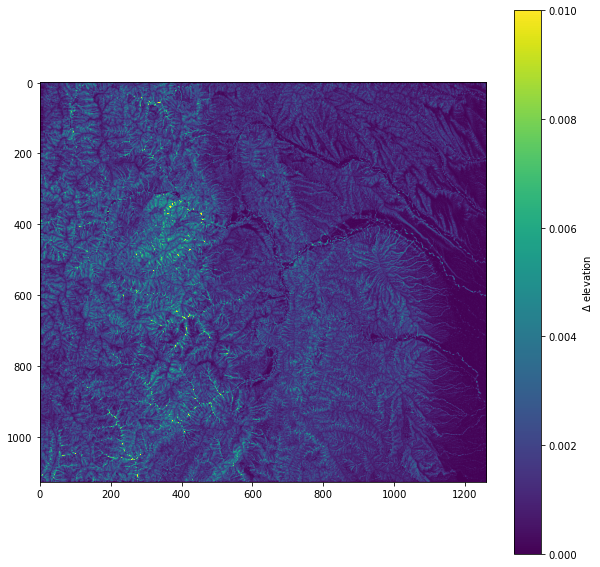

In [20]:
nrows = raster["nrows"]
ncols = raster["ncols"]
fig,ax = plt.subplots(figsize = (10,10))

# cb = ax.imshow(model.get_array_double_param("surface_elevation_tp1").reshape(raster["nrows"],raster["ncols"])- Z.reshape(raster["nrows"],raster["ncols"]), 
#      cmap = "viridis", vmin= -1, vmax = 1)
# model.get_water_flux()
cb = ax.imshow(model.get_array_double_param("surface_elevation_tp1").reshape(raster["nrows"],raster["ncols"]), vmin =0,
     cmap = "viridis")
cb = ax.imshow(model.get_erosion_flux().reshape(nrows,ncols), cmap = "viridis",vmax = 0.01)
# cb = ax.imshow(model.get_all_nodes_in_depression().reshape(nrows,ncols), cmap = "viridis")

# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[600:700,400:500] - Zp1.reshape(raster["nrows"],raster["ncols"])[600:700,400:500], 
#     vmin = -0.1,vmax = 0.5, cmap = "viridis")
# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[550:650,400:500], cmap = "viridis",vmin = 500, vmax = 800 )
plt.colorbar(cb, label = r"$\Delta$ elevation")


In [8]:



lsd.raster_loader.save_raster(model.get_other_attribute("lake_depth").reshape(raster["nrows"],raster["ncols"]),
    raster["x_min"],raster["x_max"],raster["y_max"],raster["y_min"],raster["res"],raster["crs"],"dpr.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(baselevel_2(prestack,prerec,postsrec,Z).reshape(raster["nrows"],raster["ncols"]),
    raster["x_min"],raster["x_max"],raster["y_max"],raster["y_min"],raster["res"],raster["crs"],"BL.tif", fmt = 'GTIFF')

flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub


node: 1302.0 rec: 1302.0
flub
flub
flub
flub
flub
flub
node: 59.0 rec: 59.585784912109375
flub
flub
flub
flub
flub
flub
node: 52.0 rec: 52.585784912109375
node: 1283.0 rec: 1284.80810546875
flub
flub
flub
flub
flub
flub
node: 54.0 rec: 54.0
flub
flub
node: 54.0 rec: 54.0
flub
flub
flub
flub
flub
flub
flub
flub
node: 54.0 rec: 54.414215087890625
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
node: 63.0 rec: 63.0
flub
flub
flub
flub
flub
flub
node: 63.0 rec: 63.0
flub
flub
node: 63.0 rec: 63.0
flub
flub
flub
flub
flub
flub
node: 1208.0 rec: 1213.4483642578125
flub
flub
flub
flub
node: 63.0 rec: 63.414215087890625
flub
flub
flub
flub
node: 1229.0 rec: 1231.7501220703125
flub
flub
flub
flub
node: 64.0 rec: 64.41421508789062
flub
flub
node: 1233.0 rec: 1234.00146484375
flub
flub
node: 1233.0 rec: 1234.00146484375
flub
flub
flub
flub
node: 63.0 rec: 63.414215087890625
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
node: 1192.0 rec: 1194.39013671875
flub
flub
node: 65.0 rec: 6

node: 168.0 rec: 168.0
node: 168.0 rec: 168.0
flub
flub
flub
flub
node: 166.0 rec: 166.0
flub
flub
node: 166.0 rec: 166.0
node: 166.0 rec: 166.0
flub
flub
flub
flub
flub
flub
node: 163.0 rec: 163.41421508789062
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
node: 166.0 rec: 166.0
node: 166.0 rec: 166.0
flub
flub
node: 166.0 rec: 166.0
node: 166.0 rec: 166.0
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
node: 171.0 rec: 171.0
node: 171.0 rec: 171.0
flub
flub
node: 171.0 rec: 171.0
node: 171.0 rec: 171.0
flub
flub
node: 171.0 rec: 171.0
node: 171.0 rec: 171.0
flub
flub
flub
flub
flub
flub
node: 173.0 rec: 173.0
flub
flub
flub
flub
node: 172.0 rec: 172.41421508789062
flub
flub
flub
flub
flub
flub
flub
flub
node: 172.0 rec: 172.58578491210938
flub
flub
flub
flub
flub
flub
flub
flub
flub
flub
node: 174.0 rec: 174.0
flub
flub
node: 174.0 rec: 174.0
node: 174.0 rec: 174.0
flub
flub
node: 174.0 rec: 174.0
node: 174.0 rec: 174.0
flub
flub
flub
flub
node: 173.0 rec: 173.0
flub
flub
node: 

node: 293.0 rec: 293.0
node: 377.0 rec: 377.0
node: 293.0 rec: 293.0
node: 271.0 rec: 271.0
node: 274.0 rec: 274.0
node: 387.0 rec: 387.0
node: 450.0 rec: 450.0
node: 376.0 rec: 376.0
node: 389.0 rec: 389.0
node: 465.0 rec: 465.0
node: 491.90496826171875 rec: 492.0
node: 520.981689453125 rec: 522.5278930664062
node: 518.0677490234375 rec: 521.0
node: 458.0 rec: 459.8540954589844
node: 458.0 rec: 462.0928039550781
node: 447.0 rec: 450.1572570800781
node: 446.0 rec: 447.8097839355469
node: 446.0 rec: 447.8097839355469
node: 446.0 rec: 447.8097839355469
node: 446.0 rec: 446.0
node: 452.0 rec: 453.0
node: 450.0 rec: 453.5029602050781
node: 455.0 rec: 459.2209167480469
node: 476.0 rec: 484.5304870605469
flub
flub
node: 120.0 rec: 120.0
node: 120.0 rec: 120.0
node: 183.0 rec: 183.0
node: 210.0 rec: 210.0
node: 293.0 rec: 293.0
node: 377.0 rec: 377.0
node: 293.0 rec: 293.0
node: 271.0 rec: 271.0
node: 274.0 rec: 274.0
node: 387.0 rec: 387.0
node: 450.0 rec: 450.0
node: 376.0 rec: 376.0
node: 

In [6]:
raster["crs"]

'epsg:32635'

In [17]:
Z[1135049]

550.0

In [12]:
#raster name putna_50_NDF
raster = lsd.raster_loader.load_raster("putna_50_NDF.tif")

In [13]:
stack = fstctx.mstack.astype('int') - 1
nb_receivers = fstctx.mnrec.astype('int')
receivers = fstctx.mrec.astype('int').transpose() - 1
lengths = fstctx.mlrec.transpose()
weights = fstctx.mwrec.transpose()

sstack = fstctx.stack.astype('int') - 1
sreceivers = fstctx.rec.astype('int') - 1

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
receivers[5300]

In [ ]:
# fstctx.mstack.astype("int")
checker = check_stack(stack)
checker = checker.reshape(raster["nrows"],raster["ncols"])
pits, recapit = try_identify_pits(receivers, raster["array"].astype(np.float32).ravel(), stack)
# pits, recapit = try_identify_pits_single(sreceivers, raster["array"].astype(np.float32).ravel(), sstack)

fig,ax = plt.subplots(figsize = (10,12))
cb = ax.imshow(raster["array"][500: 520, 695:715 ], cmap = "gray", vmin = 300, vmax = 400)
cb =ax.imshow(checker[500: 520,695:715 ], alpha=1, cmap = "magma")
# cb =ax.imshow(nb_receivers.reshape(raster["nrows"],raster["ncols"]), alpha=1, cmap = "magma")
colspit = pits % raster["ncols"]
rowspit = ((pits - colspit)/ raster["ncols"]).astype(np.int32)

rcolspit = recapit % raster["ncols"]
rrowspit = ((recapit - rcolspit)/ raster["ncols"]).astype(np.int32)

# ax.scatter(colspit, rowspit, lw = 0, c = "yellow")
# ax.scatter(rcolspit, rrowspit, lw = 0, c = "green")

# ax.set_xlim(695,715)
# ax.set_ylim(520, 500)

print(receivers[0])
print(stack.shape)

plt.colorbar(cb)

In [ ]:
cols = stack % raster["ncols"]
rows = ((stack - cols)/ raster["ncols"]).astype(np.int32)
import lsdtopytools as lsd
mydem = lsd.LSDDEM(file_name ="putna_50_NDF.tif", already_preprocessed = True )
X,Y = mydem.cppdem.query_xy_from_rowcol(rows,cols)
import pandas as pd
pd.DataFrame({"incr": checker.ravel(), "X": X, "Y":Y}).to_csv("checker.csv", index = False)

In [ ]:
bite =  np.zeros(fstctx.nn)
bc =  np.zeros(fstctx.nn)

dx = fstctx.xl/(fstctx.nx - 1)
dy = fstctx.yl/(fstctx.ny - 1)
i1 = np.int32(0)
i2 = np.int32(0)
j1 = np.int32(0)
j2 = np.int32(0)
xcyclic = np.bool(0)
ycyclic = np.bool(0)

fs.set_bc(fstctx.ibc, fstctx.nx, fstctx.ny) #, i1, i2, j1, j2, bc, xcyclic, ycyclic)
fs.find_receiver(fstctx.h,fstctx.nx,fstctx.ny,dx,dy,i1,i2,j1,j2,xcyclic, ycyclic)


In [ ]:
fs.fastscape_destroy()